In [1]:
import sys
sys.path.append('/Users/admin/Desktop/tesi/Thesis/')
from skimage.filters import gaussian
from handcrafted_descriptors.descriptor import binary_gabor_features as bgf
import import_ipynb
from handcrafted_descriptors.gabor_classification import utility as utility 
import numpy as np 
from matplotlib import pyplot as plt

importing Jupyter notebook from /Users/admin/Desktop/tesi/Thesis/handcrafted_descriptors/gabor_classification/utility.ipynb


In [2]:
species = ['Arthonia_radiata','Caloplaca_cerina','Candelariella_reflexa','Candelariella_xanthostigma','Chrysothrix_candelaris','Flavoparmelia_caperata','Gyalolechia_flavorubescens','Hyperphyscia_adglutinata'
        ,'Lecanora_argentata','Lecanora_chlarotera','Lecidella_elaeochroma','Melanelixia_glabratula'
        ,'Phaeophyscia_orbicularis','Physcia_biziana','Physconia_grisea','Ramalina_farinacea','Ramalina_fastigiata','Xanthomendoza_fallax','Xanthomendoza_fulva','flavoparmenia_soredians']


In [4]:
def getDescriptors(img, halflength = 15):
    img_r = img[:,:,0]
    img_g = img[:,:,1]
    img_b = img[:,:,2]   
    feat_1 = bgf.BGF(img_r, 200,200,50, halflngt = halflength, all = True)
    feat_2 = bgf.BGF(img_g, 200,200,50, halflngt = halflength, all = True)
    feat_3 = bgf.BGF(img_b, 200,200,50, halflngt = halflength, all = True)
    res = np.concatenate([feat_1, feat_2, feat_3])
    return res 

In [5]:
def extract_descriptors(path,hlf,train = True, specs = species):
    images_pth, label_dict = utility.getPath_and_dict(path, train)
    print(len(images_pth))
    descriptor_list = [] 
    train_labels = []
    image_count = len(images_pth) 
    for i,img_path in enumerate(images_pth):
        cl = img_path.split('/')[-2]
        class_index = species.index(cl)
        train_labels.append(class_index)        
        img = utility.readimage(img_path)
        dsc = getDescriptors(img, halflength = hlf)
        if(i%200==0):
            print(dsc.shape)
        descriptor_list.append(dsc)     
    descriptors =np.array(descriptor_list)
    train_labels = np.array(train_labels)
    return descriptors, train_labels, images_pth

## MAIN ---> BINARY GABOR FEATURE

In [10]:
feat,lab,_ = extract_descriptors('../../../data/train', hlf = 5)
feat = feat.reshape((1121,648))
print('end training')
test_feat, test_lab,image_list = extract_descriptors('../../../data/valid', hlf = 5, train = False)
test_feat = test_feat.reshape((456,648))

1121
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
(648, 1)
end training
456
(648, 1)
(648, 1)
(648, 1)


In [11]:
svm ,score_rbf = utility.search_for_best_rbf(feat, lab, test_feat, test_lab)

Best estimator found by grid search :  SVC(C=100.0, gamma=1)
Accuracy score : 0.8267543859649122


[[18.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  3.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. 20.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 3.  0. 21.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. 29.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. 11.  0.  0. 13.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0. 13.  0.  0.  1.  0.  0.  0.  2.  0. 12.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0. 12.  0.  0.  1.  1.  0.  0.  0.  0.  2.  2.  0.
   0.  0.]
 [ 2.  0.  0.  0.  1.  0.  0. 24.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. 18.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0. 23.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 16.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. 19.  0.  0.  0.  0.

(0.8499133900103558, 0.8331273291925466, 0.8262613188961925)

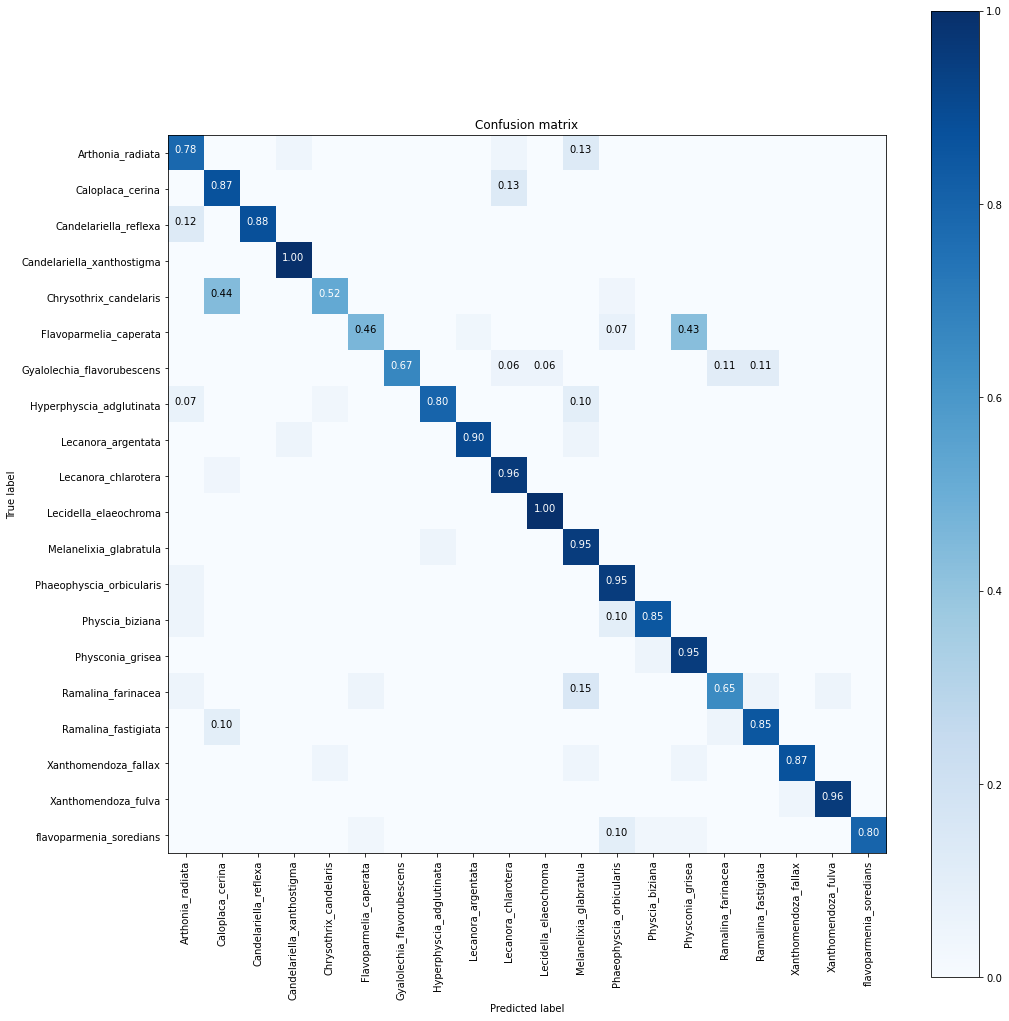

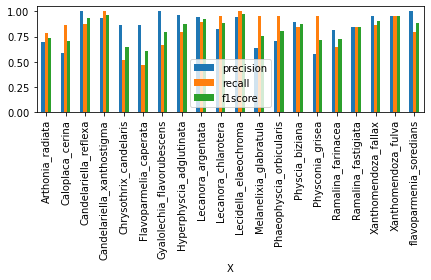

In [12]:
halfln = 5
director_cm = 'results/results_bgp/confusion_matrix/'
name_cm = 'newcm_'+ str(halfln)
pred = utility.create_and_save_confusion_matrix(svm, test_feat, test_lab, species, director_cm, name_cm)

director_pra = 'results/results_bgp/pra/'
name_pra = 'newpra_' + str(halfln)
utility.calculate_and_plot_precision_recall(test_lab, pred, species, director_pra, name_pra)